## <font color='green'> <div align="center">In the name of God </div></font>

### <font color='red'> Author: Sayed Kamaledin Ghiasi-Shrirazi <a href="http://profsite.um.ac.ir/~k.ghiasi">(http://profsite.um.ac.ir/~k.ghiasi)</a> </font>

# Comparing running time of traditional <font color='red'>eigen</font> and the novel <font color='red'>lstsq</font> solvers for Fisher LDA

##### Importing general modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import sklearn
import scipy.stats as st
import time
import matplotlib as mpl

##### Importing modules wtitten by the author

In [2]:
from LinearDiscriminantAnalysis import LinearDiscriminantAnalysis
from LDATrainingDataPreparation import TrainingData

##### Defining a function for generating N samples of dimension dim

The data comes from a 2-class classification problem, where each class consists of 3 clusters.
Samples are drawn from Gaussian distributions with a specific covariance matrix.
Here, I have generated samples without **np.random.multivariate_normal** to speedup dataset generation.

In [3]:
def prepareDataset (N, dim):
    nClasses = 3
    nClusters = 1
    theta = np.pi / 4
    p3 = 1 / 3
    p2 = 1 / 3
    p1 = 1 / 3
    Ki = np.array([1, 1, 1], dtype=int)
    NKi = np.array([[p1 * N], [p2 * N], [p3 * N]], dtype=int)
    position = np.array([[[0, -1]], [[0, 0]], [[0, 1]]])

    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    means = np.zeros([nClasses, nClusters, dim])
    for i in range(nClasses):
        for j in range(nClusters):
            x, y = position[i, j]
            m = R @ np.sqrt(np.diag([1, 4])) @ np.array([x, y]) * 5 / np.sqrt(2)
            means[i, j, 0] = m[0]
            means[i, j, 1] = m[1]
            means[i, j, 2:] = 0

    scales = [0.25, 9]
    S = np.diag(scales)
    cov2 = R @ S @ R.T
    cov = np.zeros([dim, dim])
    cov[0:2, 0:2] = cov2
    for i in range(2, dim):
        cov[i, i] = scales[0]

    N = np.sum (NKi)
    XTrain = np.zeros ([N, dim])
    yTrain = np.zeros (N)
    idx = 0
    for i in range (nClasses):
        for j in range(nClusters):
            Xi_first = np.random.multivariate_normal (np.zeros(2), cov2, NKi[i, j])
            Xi_rest = np.random.randn(NKi[i, j], dim-2)
            Xi_rest *= scales[0]
            Xi = np.hstack([Xi_first,Xi_rest])
            Xi += means[i,j,:]            
            #Xi = np.random.multivariate_normal (means[i,j,:], cov, NKi[i, j])
            XTrain[idx:idx + NKi[i, j], :] = Xi
            yTrain[idx:idx + NKi[i, j]] = i
            idx += NKi[i, j]

    yTrain = np.array(yTrain, dtype='int')

    td = TrainingData(XTrain, yTrain)
    td.setSubclasses(Ki, NKi)
    return td, means

##### Defining a function for measuring running time of a solver on a dataset.

In [4]:
def performExperiment(td, solver, metric_learning):
    lda = LinearDiscriminantAnalysis(td, solver, metric_learning, 'Sb', 'St', 0.00, 0.0001)

    start = time.time()
    # I set normalize to Falase, so that EIG-LDA++ solution can be computed based on LDA++
    lda.fitFeatureExtractor(normalize = False)
    end = time.time()
    
    # Since, now, the scatter matrices have been computed,
    # This second call computes the pure time for solving LDA
    lda.fitFeatureExtractor(normalize = False)
    end2 = time.time()
    obj = lda.objective()
    return end - start, end2 - end, obj, lda

##### Performing experiments on N=36000 samples with different dimensions

In [5]:
N = 36000
rep = 5
runtimeTable = np.zeros([3,14-8, rep])
objTable = np.zeros([3,14-8, rep])
for r in range(rep):
    for logDim in range(8,14):
        dim = 2 ** logDim
        (td, _) = prepareDataset (N, dim)

        solver = 'eigen'
        runTime, runTimePure, obj, _ = performExperiment (td, solver, '')
        print ('For solver {:>15}, N = {}, dim = {} runtime is {:.4f}, '
               'pure runtime is {:.4f}, objective = {:.4f}'.format(solver, N, dim, runTime, runTimePure, obj))
        runtimeTable[0,logDim-8, r] = runTime
        objTable[0,logDim-8, r] = obj

        solver = 'ghiasi_lstsq'
        metric_learning = 'none'
        runTime, runTimePure, obj, lda = performExperiment (td, solver, metric_learning)
        print ('For solver {:>15}, metric_learning {}, N = {}, dim = {} runtime is {:.4f}, '
               'pure runtime is {:.4f}, objective = {:.4f}'.format(solver, metric_learning, N, dim, runTime, runTimePure, obj))
        runtimeTable[1,logDim-8, r] = runTime
        objTable[1,logDim-8, r] = obj

        #inaccurate method:
            #solver = 'ghiasi_lstsq'
            #metric_learning = 'eig'
            #runTime, runTimePure, obj = performExperiment (td, solver, metric_learning)
        start = time.time()
        for _ in range (100):
            A = lda.model
            Q = np.diag(lda.Li / np.sum(lda.Li))
            B = Q @ lda.Mi @ A.T
            (eigvalsZ, Z) = np.linalg.eig(B)
            idx = eigvalsZ.argsort()[::-1]
            Z = Z[:,idx]
            eigvalsZ = eigvalsZ[idx]
            # Since we extract L features, Z is singular.
            # However, it should not have more than one zero eigenvalue.
            # Otherwise the objective function would decrease.
            if eigvalsZ[-2] > 1e-12:
                A = Z.T @ A
            else:
                print ('Z not applied.')        
        end = time.time()
        metric_learning_time = (end - start) / 100    
        print ('For solver {:>15}, metric_learning {}, N = {}, dim = {} runtime is {:.4f}, '
               'pure runtime is {:.4f}, objective = {:.4f}'.format(
                   solver, metric_learning, N, dim, runTime+metric_learning_time, runTimePure+metric_learning_time, obj))
        runtimeTable[2,logDim-8, r] = runTime + metric_learning_time
        objTable[2,logDim-8, r] = obj

        #solver = 'ghiasi_pinv'
        #runTime, runTimePure, obj = performExperiment (td, solver)
        #print ('Runnig time for solver {:>15}, N = {}, dim = {} is {} with objective = {}'.format(solver, N, dim, runTime, obj))
        #table[4,logDim-8] = runTime    

        #solver = 'svd'
        #runTime, obj = performExperiment (td, solver)
        #print ('Runnig time for solver {:>15}, N = {}, dim = {} is {} with objective = {}'.format(solver, N, dim, runTime, obj))
        #table[2,logDim-8] = runTime

        #solver = 'ghiasi_svd'
        #runTime, obj = performExperiment (td, solver)
        #print ('Runnig time for solver {:>15}, N = {}, dim = {} is {} with objective = {}'.format(solver, N, dim, runTime, obj))
        #table[3,logDim-8] = runTime


        print ('----------------------------------------------')

For solver           eigen, N = 36000, dim = 256 runtime is 0.1391, pure runtime is 0.0312, objective = 0.7945
For solver    ghiasi_lstsq, metric_learning none, N = 36000, dim = 256 runtime is 0.1471, pure runtime is 0.0378, objective = 0.7945
For solver    ghiasi_lstsq, metric_learning none, N = 36000, dim = 256 runtime is 0.1471, pure runtime is 0.0378, objective = 0.7945
----------------------------------------------
For solver           eigen, N = 36000, dim = 512 runtime is 0.4424, pure runtime is 0.0846, objective = 0.8040
For solver    ghiasi_lstsq, metric_learning none, N = 36000, dim = 512 runtime is 0.4850, pure runtime is 0.1315, objective = 0.8040
For solver    ghiasi_lstsq, metric_learning none, N = 36000, dim = 512 runtime is 0.4852, pure runtime is 0.1316, objective = 0.8040
----------------------------------------------
For solver           eigen, N = 36000, dim = 1024 runtime is 1.6191, pure runtime is 0.4322, objective = 0.8213
For solver    ghiasi_lstsq, metric_learn

For solver    ghiasi_lstsq, metric_learning none, N = 36000, dim = 512 runtime is 0.5056, pure runtime is 0.1159, objective = 0.8067
For solver    ghiasi_lstsq, metric_learning none, N = 36000, dim = 512 runtime is 0.5058, pure runtime is 0.1160, objective = 0.8067
----------------------------------------------
For solver           eigen, N = 36000, dim = 1024 runtime is 1.6464, pure runtime is 0.4231, objective = 0.8225
For solver    ghiasi_lstsq, metric_learning none, N = 36000, dim = 1024 runtime is 1.9226, pure runtime is 0.7173, objective = 0.8225
For solver    ghiasi_lstsq, metric_learning none, N = 36000, dim = 1024 runtime is 1.9227, pure runtime is 0.7174, objective = 0.8225
----------------------------------------------
For solver           eigen, N = 36000, dim = 2048 runtime is 6.7420, pure runtime is 2.3272, objective = 0.8569
For solver    ghiasi_lstsq, metric_learning none, N = 36000, dim = 2048 runtime is 8.4260, pure runtime is 4.2573, objective = 0.8569
For solver    

In [12]:
for logDim in range(8,14):
    d = 2 ** logDim
    i = logDim - 8
    print (d, '&', '%0.4f'%np.mean(runtimeTable[0,i,:]), 
              '&', '%0.4f'%np.mean(runtimeTable[1,i,:]), 
              '&', '%0.4f'%np.mean(runtimeTable[2,i,:]), '\\\\')

256 & 0.1644 & 0.1622 & 0.1623 \\
512 & 0.4502 & 0.5075 & 0.5076 \\
1024 & 1.6411 & 1.9415 & 1.9416 \\
2048 & 6.6982 & 8.4851 & 8.4853 \\
4096 & 32.6432 & 45.1203 & 45.1207 \\
8192 & 189.1050 & 276.0101 & 276.0114 \\


In [13]:
for logDim in range(8,14):
    for r in range(rep):
        d = 2 ** logDim
        i = logDim - 8
        print (d, '&',  '%0.4f'%objTable[0,i,r], '&', '%0.4f'%objTable[1,i,r], '&', '%0.4f'%objTable[2,i,r])

256 & 0.7945 & 0.7945 & 0.7945
256 & 0.7956 & 0.7956 & 0.7956
256 & 0.7955 & 0.7955 & 0.7955
256 & 0.7966 & 0.7966 & 0.7966
256 & 0.7964 & 0.7964 & 0.7964
512 & 0.8040 & 0.8040 & 0.8040
512 & 0.8046 & 0.8046 & 0.8046
512 & 0.8039 & 0.8039 & 0.8039
512 & 0.8067 & 0.8067 & 0.8067
512 & 0.8069 & 0.8069 & 0.8069
1024 & 0.8213 & 0.8213 & 0.8213
1024 & 0.8177 & 0.8177 & 0.8177
1024 & 0.8225 & 0.8225 & 0.8225
1024 & 0.8225 & 0.8225 & 0.8225
1024 & 0.8216 & 0.8216 & 0.8216
2048 & 0.8556 & 0.8556 & 0.8556
2048 & 0.8564 & 0.8564 & 0.8564
2048 & 0.8568 & 0.8568 & 0.8568
2048 & 0.8569 & 0.8569 & 0.8569
2048 & 0.8588 & 0.8588 & 0.8588
4096 & 0.9256 & 0.9256 & 0.9256
4096 & 0.9241 & 0.9241 & 0.9241
4096 & 0.9266 & 0.9266 & 0.9266
4096 & 0.9261 & 0.9261 & 0.9261
4096 & 0.9247 & 0.9247 & 0.9247
8192 & 1.0616 & 1.0616 & 1.0616
8192 & 1.0679 & 1.0679 & 1.0679
8192 & 1.0628 & 1.0628 & 1.0628
8192 & 1.0642 & 1.0642 & 1.0642
8192 & 1.0635 & 1.0635 & 1.0635


##### Depicting the distribution of data

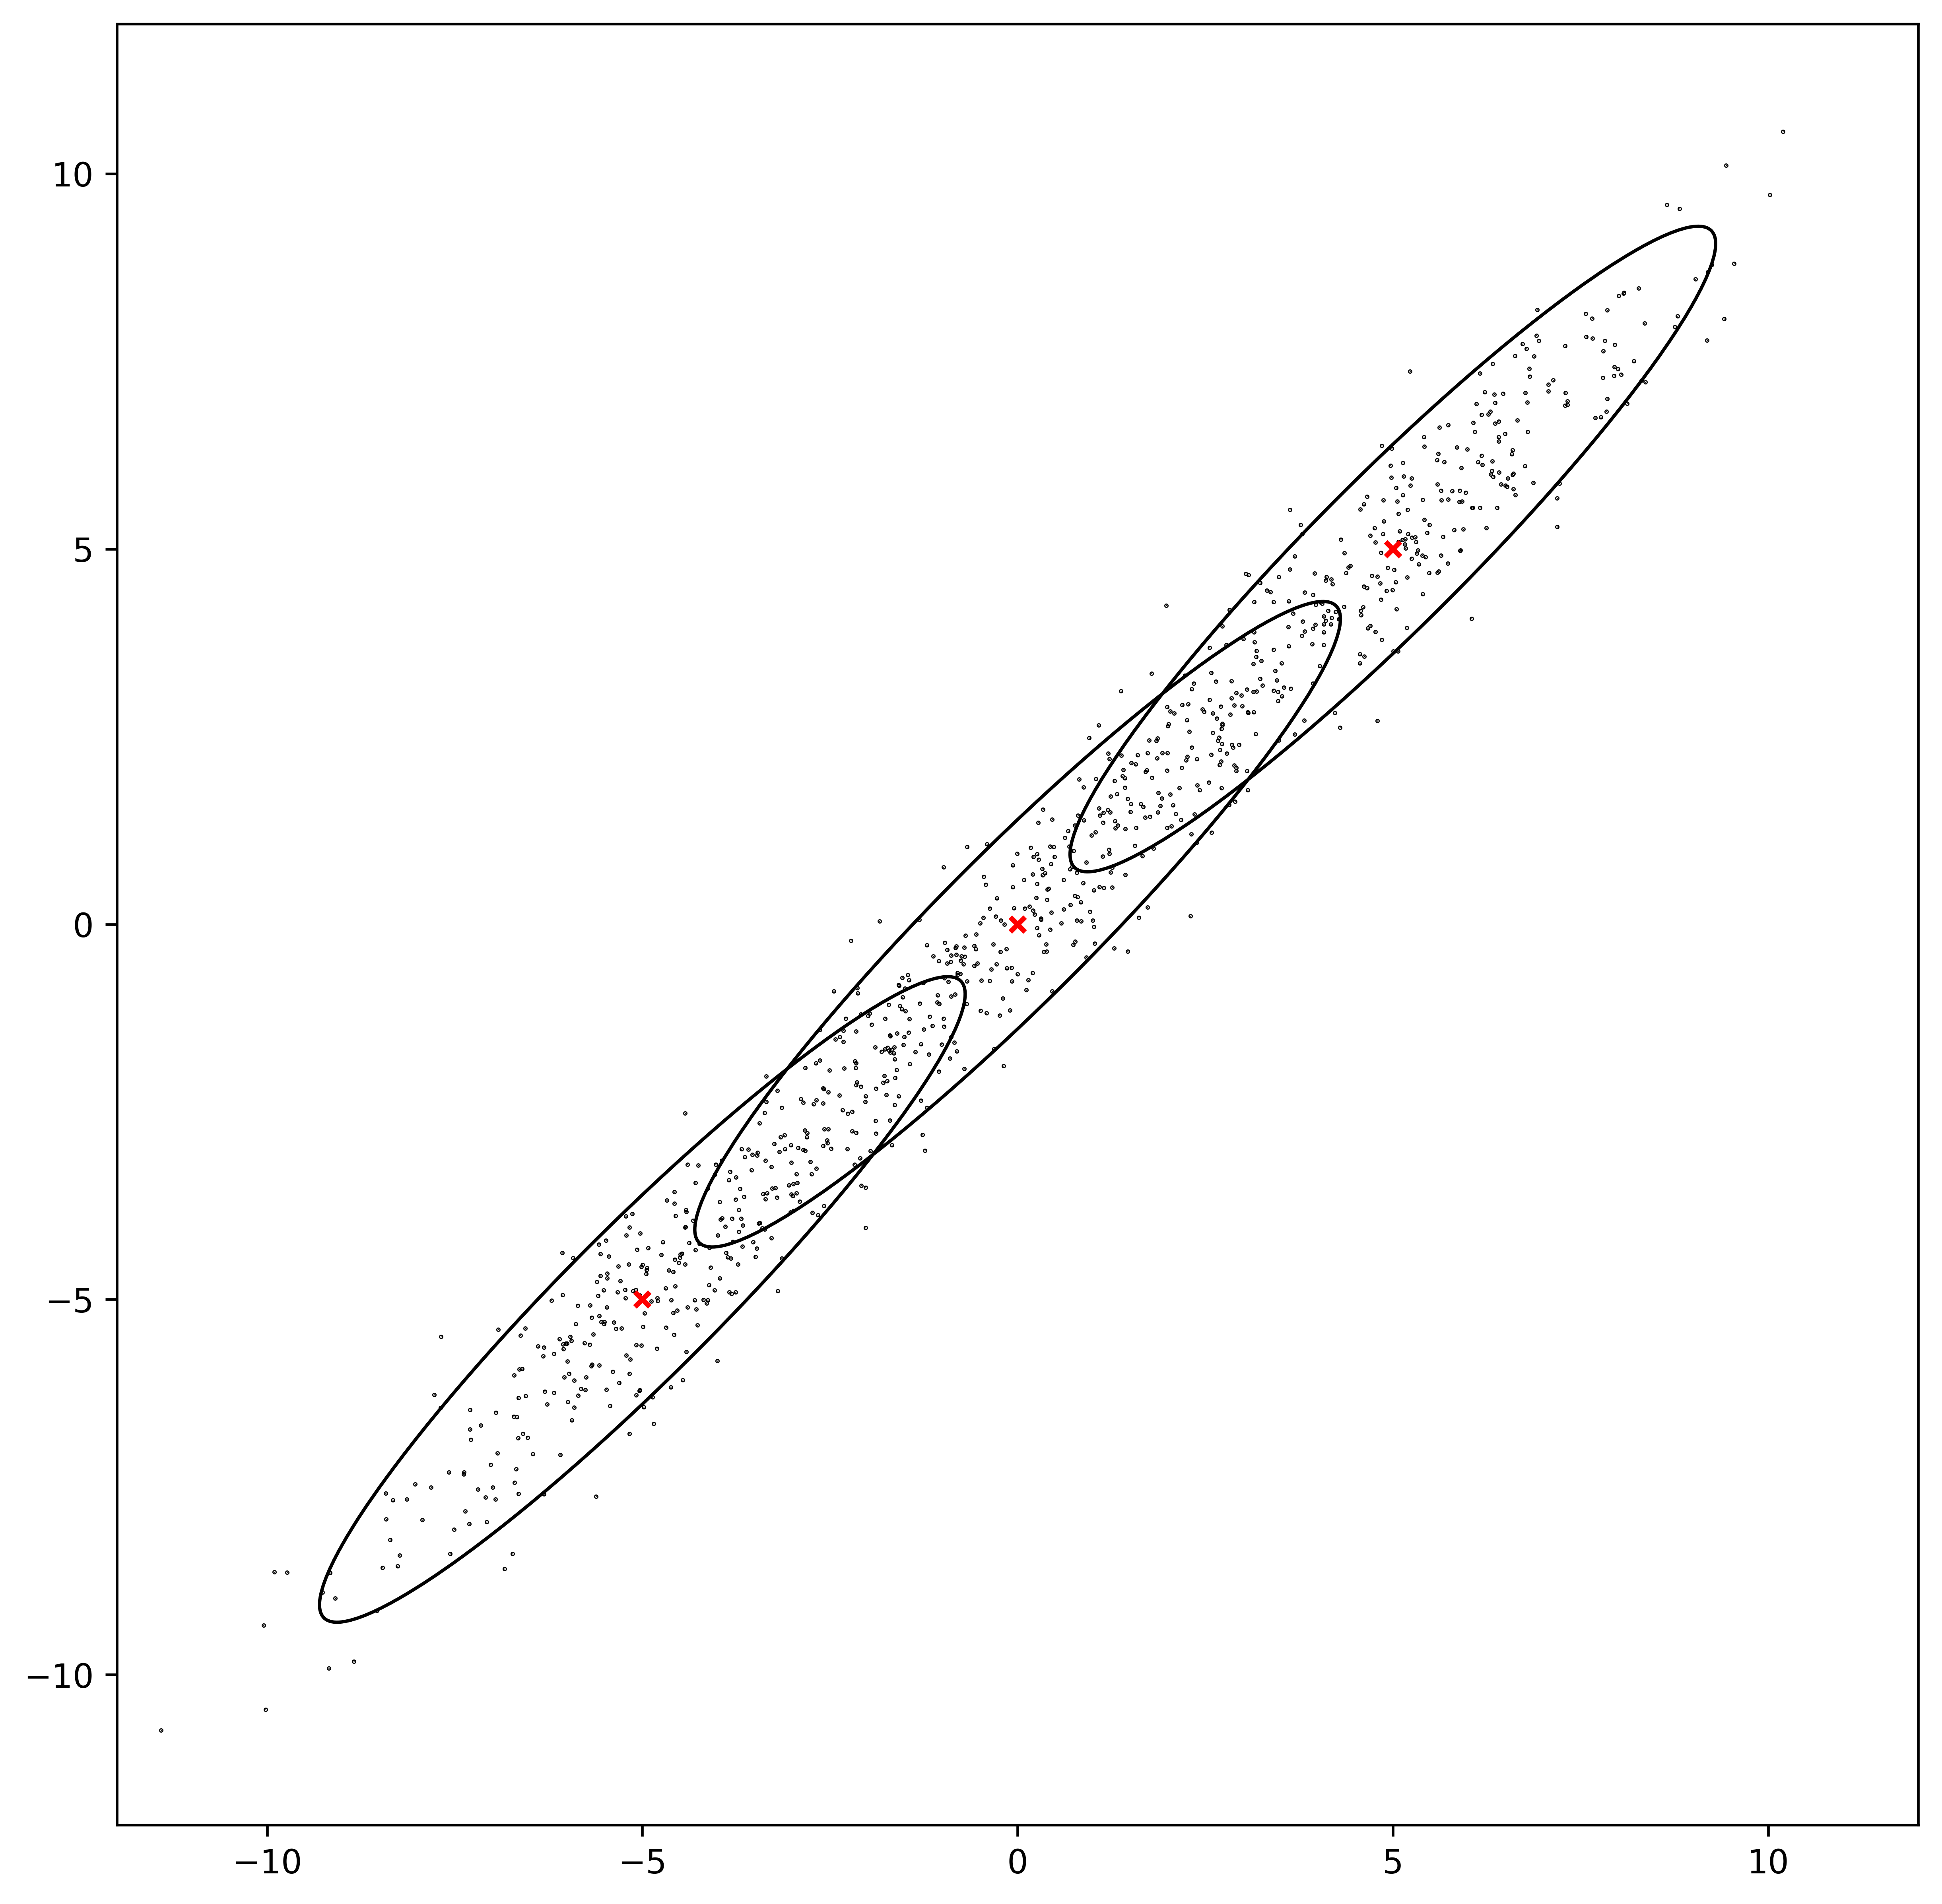

In [14]:
td, means = prepareDataset (1000, 128)
nClasses = 3
nClusters = 1
scales = [0.25, 9]
%matplotlib inline
mpl.rcParams['figure.dpi']= 600
plt.figure(figsize=[10,10])
ax = plt.subplot(111, aspect='equal')
color_map = np.array(['blue', 'green', 'black'])
plt.scatter(td.X[:, 0], td.X[:, 1], s=0.1, c='black')
means_computed = means[:,:,0:2].reshape([-1,2])
plt.scatter(means_computed[:,0], means_computed[:,1], s=20, marker='x', c='red')
s = 4
for i in range (nClasses):
    for j in range(nClusters):
        width = np.sqrt(scales[0]) * s
        height = np.sqrt(scales[1]) * s
        e = Ellipse(means[i,j,0:2], width, height, -45, facecolor = 'none', edgecolor = 'k')
        ax.add_artist(e)
plt.xlim(-12, 12)
plt.ylim(-12, 12)
#plt.axis('off')
plt.show()

### <font color='red'> Author: Sayed Kamaledin Ghiasi-Shrirazi <a href="http://profsite.um.ac.ir/~k.ghiasi">(http://profsite.um.ac.ir/~k.ghiasi)</a> </font>